# **Image Classification Using CNN and Transfer Learning**

This project focuses on building an image classification model using two approaches: Custom Convolutional Neural Network (CNN) and Transfer Learning with ResNet50.

**What is Transfer Learning** <br>
Transfer learning is a machine learning technique where a pre-trained model, trained on a large dataset, is reused for a different but related task. Instead of starting from scratch, the model leverages learned features, like edges or textures, to improve performance and reduce training time for the new task. This approach is especially effective when the new dataset is smaller or lacks extensive labeled data.

**classes are**:
- buildings
- forest
- glacier
- mountain
-  sea
-  street

**Importing Necessary Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy


**fetches a ZIP file from Google Drive, saves it locally, and then extracts the ZIP file's contents into that directory.**

In [2]:
import gdown
import zipfile
import os

# Define the Google Drive file ID and download URL
file_id = '1VZazTsIQ1hNA3ykK_4TY-ShVtRTwn43Q'
download_url = f'https://drive.google.com/uc?id={file_id}'

# Download the file to a temporary location
output_path = '/content/downloaded_file.zip'
gdown.download(download_url, output_path, quiet=False)

# Define the output directory and unzip
output_dir = '/content'
os.makedirs(output_dir, exist_ok=True)

# Unzip the file only once
with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print("Files extracted to:", output_dir)


Downloading...
From (original): https://drive.google.com/uc?id=1VZazTsIQ1hNA3ykK_4TY-ShVtRTwn43Q
From (redirected): https://drive.google.com/uc?id=1VZazTsIQ1hNA3ykK_4TY-ShVtRTwn43Q&confirm=t&uuid=1001c068-39c4-4a32-b976-d5168bc56f0c
To: /content/downloaded_file.zip
100%|██████████| 363M/363M [00:07<00:00, 51.9MB/s]


Files extracted to: /content


**Train and Test Path Setting**

In [3]:
# Get the Image Dataset Paths
train_dataset_path = '/content/seg_train/seg_train'
validation_dataset_path = '/content/seg_test/seg_test'

**Data Preprocessing and Augmentations**

In [4]:
# Load Image Datasets and Apply Augmentations
IMG_WIDTH = 64
IMG_HEIGHT = 64
BATCH_SIZE = 16

In [5]:
# ImageDataGenerator is a Keras utility for performing data augmentation and preprocessing on image data
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)


Found 14034 images belonging to 6 classes.


**Validation Dataset**

In [6]:
# Loading Validation Dataset
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 3000 images belonging to 6 classes.


**Label Mapping**

In [7]:
# Label Mapping
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


**Showcasing some images and their corresponding Class from the Dataset**

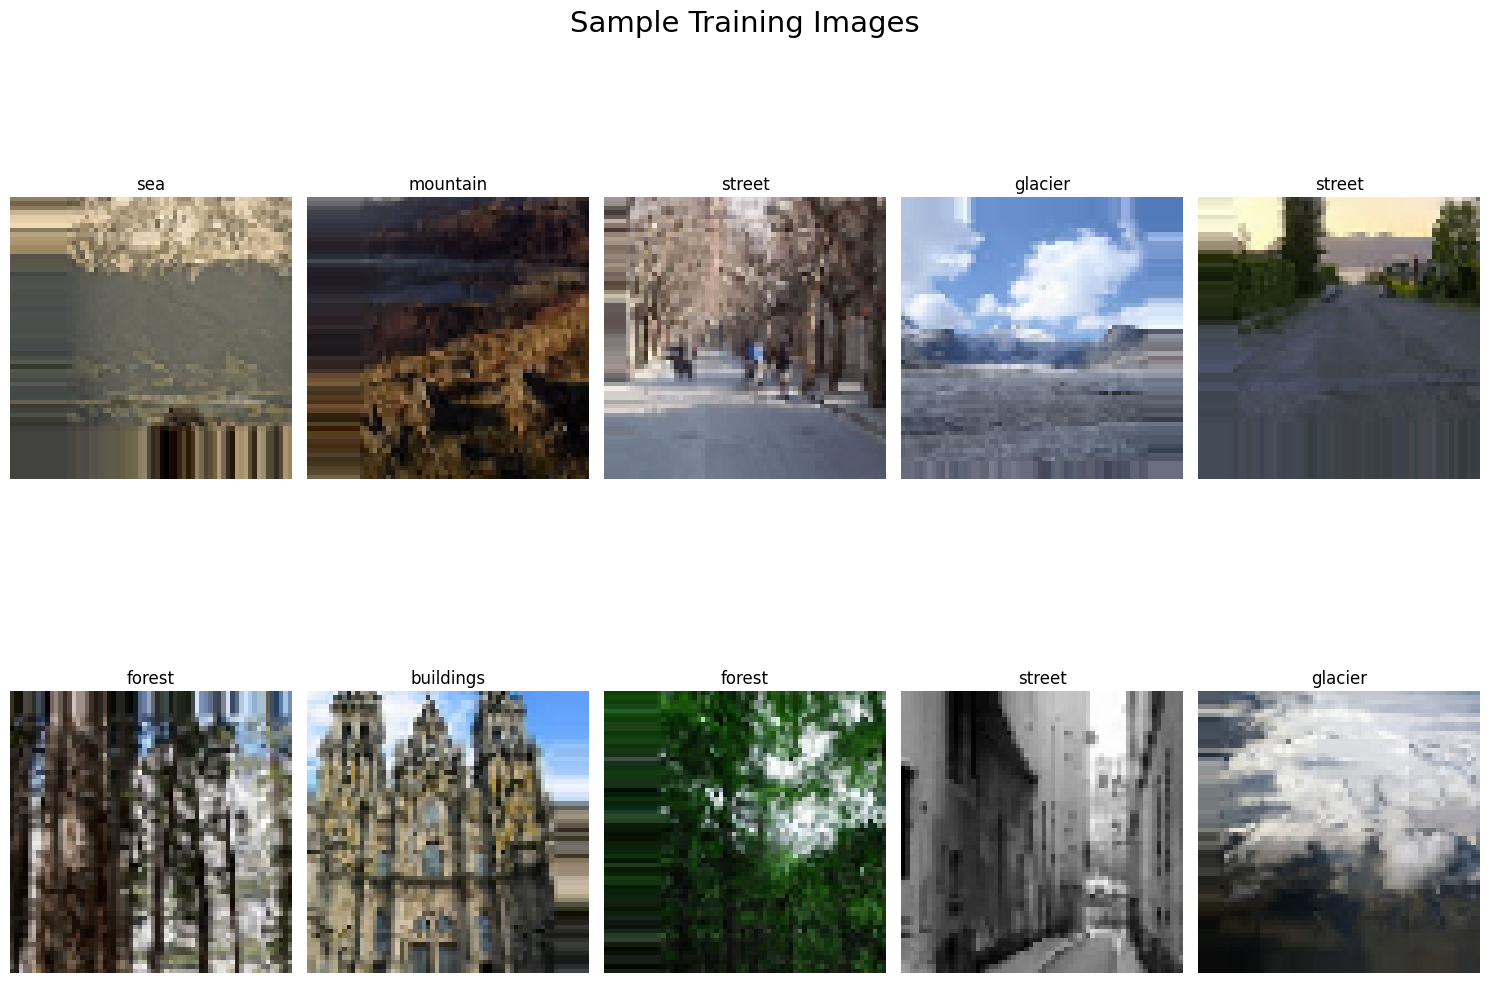

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")                                     # Turn Off Axis Lines
        idx += 1

plt.tight_layout()  # tight_layout() minimizes overlapping elements in the grid.
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

**CNN Model**

In [9]:
# creat CNN Model
def create_model():
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=16, kernel_size=(3, 3), kernel_regularizer=l2(0.00005)),  # #  reduce overfitting,
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),

        Dense(units=64, activation='relu'),
        Dropout(0.5),                           #  prevent overfitting,
        Dense(units=6, activation='softmax')
    ])
    return model

In [10]:
cnn_model = create_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
print(cnn_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 31, 31, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 29, 29, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         200,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 206,870 (808.09 KB)

 Trainable params: 206,774 (807.71 KB)

 Non-trainable params: 96 (384.00 B)

None


In [12]:
optimizer = Adam(learning_rate=0.001)

In [13]:
# compile
cnn_model.compile(optimizer=optimizer,
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])

In [14]:
# Training
history = cnn_model.fit(train_generator,
                        epochs=10,
                        validation_data=validation_generator,
                       verbose=2)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


878/878 - 40s - 45ms/step - accuracy: 0.4746 - loss: 1.4678 - val_accuracy: 0.5567 - val_loss: 1.1957
Epoch 2/10
878/878 - 30s - 34ms/step - accuracy: 0.5733 - loss: 1.1166 - val_accuracy: 0.6757 - val_loss: 0.9140
Epoch 3/10
878/878 - 29s - 33ms/step - accuracy: 0.6165 - loss: 1.0200 - val_accuracy: 0.7200 - val_loss: 0.8129
Epoch 4/10
878/878 - 41s - 46ms/step - accuracy: 0.6366 - loss: 0.9794 - val_accuracy: 0.7037 - val_loss: 0.8778
Epoch 5/10
878/878 - 29s - 33ms/step - accuracy: 0.6547 - loss: 0.9322 - val_accuracy: 0.7440 - val_loss: 0.7340
Epoch 6/10
878/878 - 44s - 50ms/step - accuracy: 0.6673 - loss: 0.9044 - val_accuracy: 0.6827 - val_loss: 0.8636
Epoch 7/10
878/878 - 29s - 33ms/step - accuracy: 0.6823 - loss: 0.8652 - val_accuracy: 0.6657 - val_loss: 0.9370
Epoch 8/10
878/878 - 41s - 46ms/step - accuracy: 0.6908 - loss: 0.8479 - val_accuracy: 0.6947 - val_loss: 0.8541
Epoch 9/10
878/878 - 42s - 47ms/step - accuracy: 0.7024 - loss: 0.8229 - val_accuracy: 0.7153 - val_loss: 0

In [15]:
train_accuracy_cnn = history.history['accuracy']
val_accuracy_cnn = history.history['val_accuracy']

train_loss_cnn = history.history['loss']
val_loss_cnn = history.history['val_loss']

**Resnet50 Transfer Learning Model**

In [16]:
def create_resnet50_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    base_model.trainable = True

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(6, activation='softmax')
    ])
    return model

In [17]:
#  ResNet50 model
resnet50_model = create_resnet50_model()

# model summary
print(resnet50_model.summary())


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2, 2, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,727,430 (90.51 MB)

 Trainable params: 23,670,214 (90.29 MB)

 Non-trainable params: 57,216 (223.50 KB)

None


In [18]:
# Optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
resnet50_model.compile(optimizer=optimizer,
                       loss=CategoricalCrossentropy(),
                       metrics=['accuracy'])

In [19]:
# Train the model
history = resnet50_model.fit(train_generator,
                             epochs=10,
                             validation_data=validation_generator,
                             verbose=2)

Epoch 1/10
878/878 - 125s - 143ms/step - accuracy: 0.4451 - loss: 1.6548 - val_accuracy: 0.3753 - val_loss: 2.0705
Epoch 2/10
878/878 - 90s - 103ms/step - accuracy: 0.5445 - loss: 1.2048 - val_accuracy: 0.4053 - val_loss: 2.1870
Epoch 3/10
878/878 - 81s - 92ms/step - accuracy: 0.4654 - loss: 1.3243 - val_accuracy: 0.3987 - val_loss: 1.8922
Epoch 4/10
878/878 - 42s - 48ms/step - accuracy: 0.5040 - loss: 1.2895 - val_accuracy: 0.5050 - val_loss: 2.4948
Epoch 5/10
878/878 - 43s - 49ms/step - accuracy: 0.5681 - loss: 1.1481 - val_accuracy: 0.4817 - val_loss: 2.5511
Epoch 6/10
878/878 - 42s - 48ms/step - accuracy: 0.5747 - loss: 1.1066 - val_accuracy: 0.4250 - val_loss: 4.9293
Epoch 7/10
878/878 - 42s - 48ms/step - accuracy: 0.5314 - loss: 1.1822 - val_accuracy: 0.5127 - val_loss: 1.7609
Epoch 8/10
878/878 - 42s - 48ms/step - accuracy: 0.5774 - loss: 1.1156 - val_accuracy: 0.6047 - val_loss: 1.0253
Epoch 9/10
878/878 - 42s - 48ms/step - accuracy: 0.5153 - loss: 1.2402 - val_accuracy: 0.5233

In [20]:
# Extract training and validation metrics
train_accuracy_resnet50 = history.history['accuracy']
val_accuracy_resnet50 = history.history['val_accuracy']

train_loss_resnet50 = history.history['loss']
val_loss_resnet50 = history.history['val_loss']

**Training and Validation Accuracy of CNN Model**

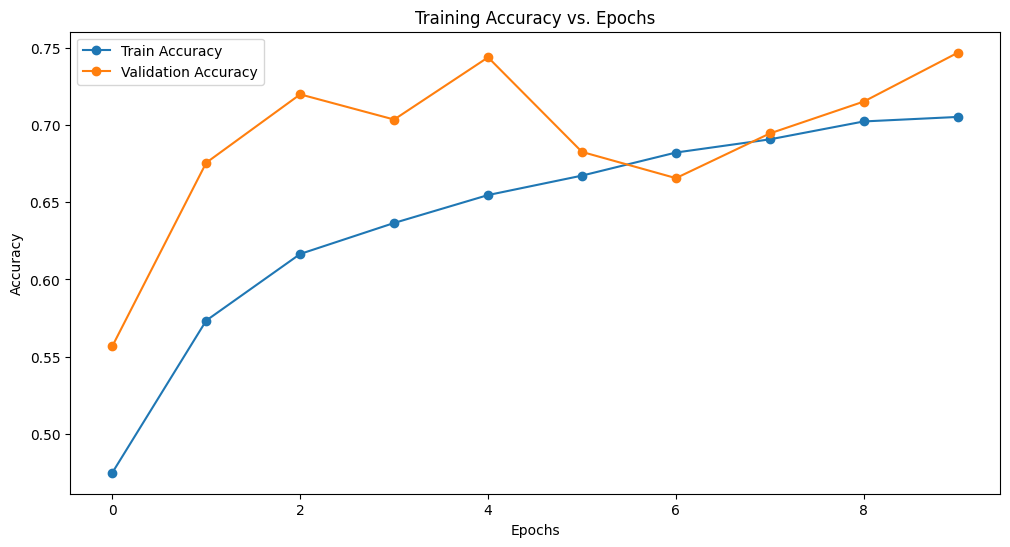

In [21]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy_cnn, 'o-', label='Train Accuracy')
plt.plot(val_accuracy_cnn, 'o-', label='Validation Accuracy')
plt.title('Training Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

**Training and Validation Accuracy of Resnet50 Model**

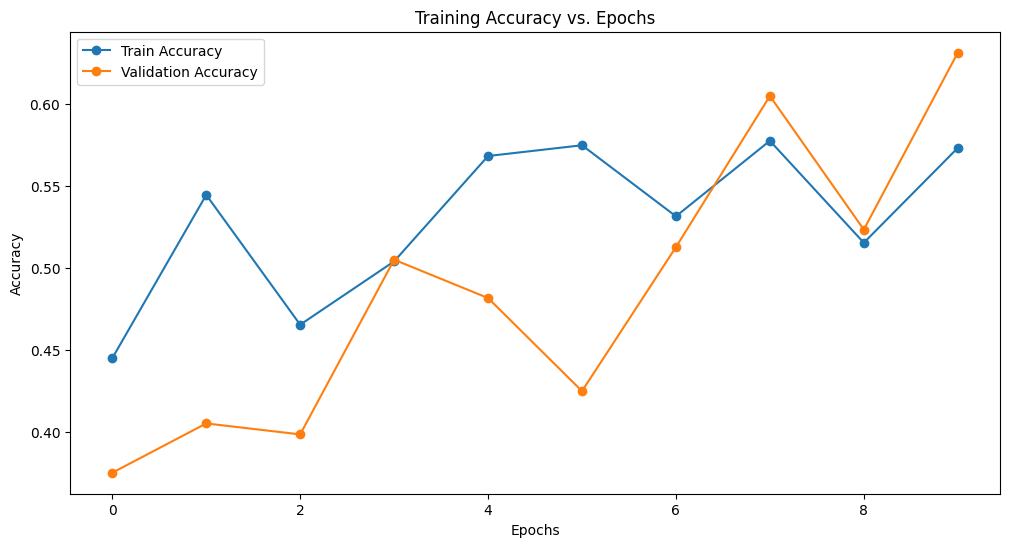

In [22]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy_resnet50, 'o-', label='Train Accuracy')
plt.plot(val_accuracy_resnet50, 'o-', label='Validation Accuracy')
plt.title('Training Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

**Model Testing**

In [23]:
test_dataset = '/content/seg_test/seg_test'

In [24]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 3000 images belonging to 6 classes.


In [25]:
# Prediction of CNN
predictions_cnn = cnn_model.predict(test_generator)
# Prediction of resnet50
predictions_resnet50 = resnet50_model.predict(test_generator)

188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step


**Showcasing some images from test dataset, predicted value and Actual Value**

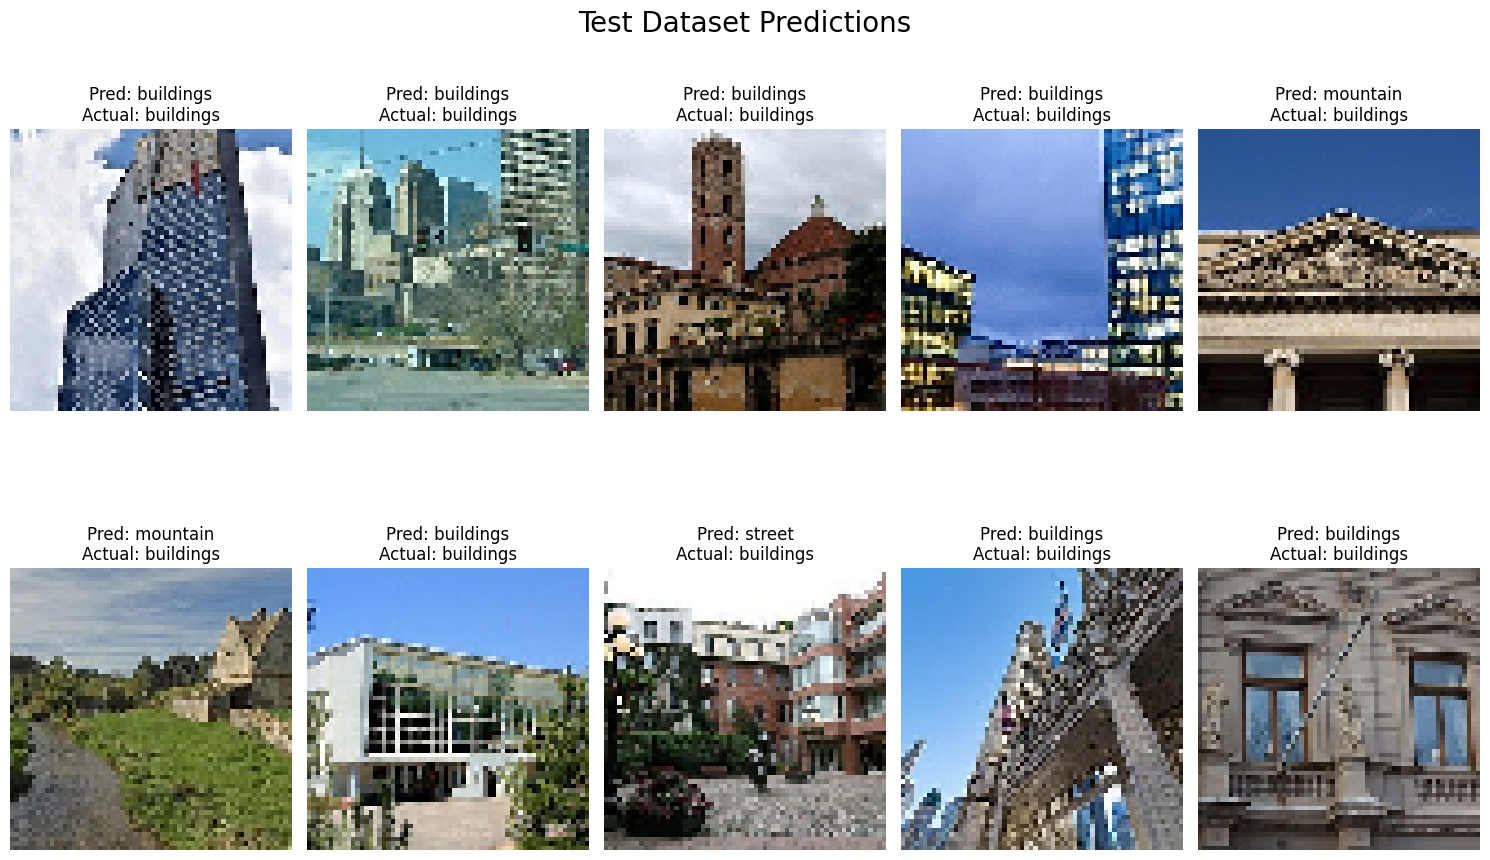

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions_cnn[idx])]  # Predicted label
        actual_label = labels[np.argmax(test_generator[0][1][idx])]  # Actual label
        ax[i, j].set_title(f"Pred: {predicted_label}\nActual: {actual_label}")
        ax[i, j].imshow(test_generator[0][0][idx])  # Display the image
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()


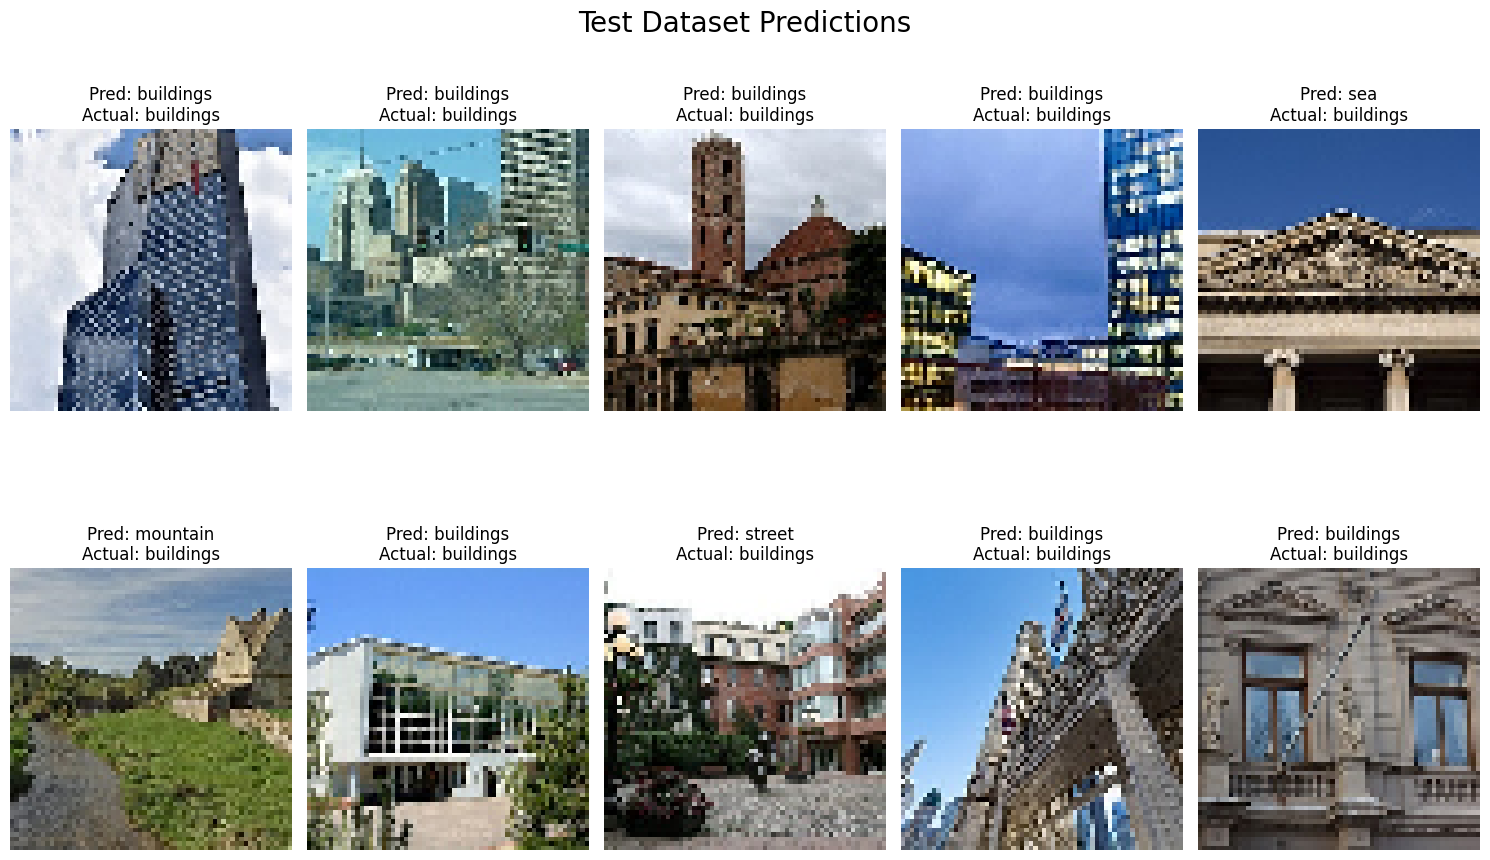

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions_resnet50[idx])]  # Predicted label
        actual_label = labels[np.argmax(test_generator[0][1][idx])]  # Actual label
        ax[i, j].set_title(f"Pred: {predicted_label}\nActual: {actual_label}")
        ax[i, j].imshow(test_generator[0][0][idx])  # Display the image
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

**Classification Report of CNN Model**

In [30]:
# Make predictions
predictions = cnn_model.predict(test_generator)
predicted_classes = np.argmax(predictions_cnn, axis=1)  # Convert probabilities to class indices
true_classes = test_generator.classes  # True class labels
class_labels = list(test_generator.class_indices.keys())  # Class names

# Classification Report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Classification Report:
              precision    recall  f1-score   support

   buildings       0.78      0.69      0.73       437
      forest       0.79      0.98      0.87       474
     glacier       0.78      0.61      0.69       553
    mountain       0.60      0.85      0.70       525
         sea       0.87      0.58      0.70       510
      street       0.78      0.79      0.78       501

    accuracy                           0.75      3000
   macro avg       0.77      0.75      0.75      3000
weighted avg       0.77      0.75      0.74      3000



Classification Report of Resnet50 Model

In [31]:
# Make predictions
predictions = resnet50_model.predict(test_generator)
predicted_classes = np.argmax(predictions_resnet50, axis=1)  # Convert probabilities to class indices
true_classes = test_generator.classes  # True class labels
class_labels = list(test_generator.class_indices.keys())  # Class names

# Classification Report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
Classification Report:
              precision    recall  f1-score   support

   buildings       0.54      0.65      0.59       437
      forest       0.84      0.82      0.83       474
     glacier       0.67      0.41      0.51       553
    mountain       0.76      0.41      0.54       525
         sea       0.48      0.79      0.60       510
      street       0.68      0.75      0.71       501

    accuracy                           0.63      3000
   macro avg       0.66      0.64      0.63      3000
weighted avg       0.66      0.63      0.62      3000



............................